In [69]:
import re
import random
import pandas as pd
import hashlib

In [70]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.75) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [71]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Azure Functions + PP365,30.483911,1.172458,26
SharePoint,192.080578,11.298858,17
Azure AI Search,371.426510,26.530465,14
Lost in a Good Book,596.811520,29.840576,20
Network Mapping,626.516241,29.834107,21
Python,681.184708,113.530785,6
Taxes,892.166062,89.216606,10
Finance Junk,1053.940568,131.742571,8
Search Engine Optimization,1200.556527,70.620972,17
PP365,1367.924790,136.792479,10


# Histogram

41672.49


<Axes: >

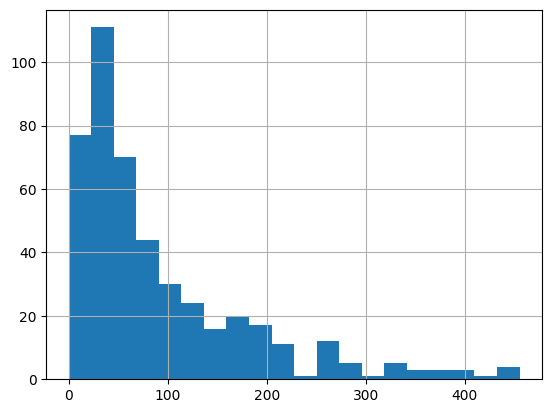

In [72]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [73]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [74]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [75]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [76]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [77]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [78]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [79]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [80]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

## Age Sum

In [81]:
# n=4
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

## Age max

In [82]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 458


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
0,Azure Functions,"By default, functions have a timeout of five (...",36721d9077790b7d88c4626328a90955,-455.176716,114.171003,-455.176716,2625.933076,0.163436,0,0
1,Azure Functions,Async HTTP APIs: This pattern addresses the pr...,1369f985bf62d84b05aefd18eaf89833,-280.675348,114.171003,-455.176716,2625.933076,0.163436,3,0
2,Azure Functions,Monitor: This pattern implements a recurring p...,356012bdd21c5dd8ed1e330d287cb0b4,-118.809868,114.171003,-455.176716,2625.933076,0.163436,6,0
3,Azure Functions,"Function chaining: In this pattern, the workfl...",a58e28f259dc349e865828c55d75d5ac,-98.434390,114.171003,-455.176716,2625.933076,0.163436,9,0
300,Azure Functions,You can use three durable function types: Clie...,042732a69490994c6100ea6a0d749d23,-53.429154,114.171003,-455.176716,2625.933076,0.163436,12,0
5,Azure Functions,Durable Functions is an extension of Azure Fun...,2cc685388fcbec98ad11f8b2bab0c4e3,-42.710846,114.171003,-455.176716,2625.933076,0.163436,15,0
6,Azure Functions,There are two types of managed identities:\n\n...,f67cf9c04025c3a0f40df04e39e17716,-29.010660,114.171003,-455.176716,2625.933076,0.163436,18,0
7,Azure Functions,Here are some of the benefits of using managed...,408c2a27d4a15f98e90519ef7a308b87,-19.765398,114.171003,-455.176716,2625.933076,0.163436,21,0
8,Diffusers from Hugging Face,"Device Management: In torch, models and data a...",5ca009995498e7262b4ab82055bd9ab6,-443.626838,204.221105,-443.626838,2042.211046,0.937125,0,0
9,Diffusers from Hugging Face,Tokenizer (CLIPTokenizer): Provided by transfo...,bc4522b67d6baa044af56334d5e45d73,-254.114362,204.221105,-443.626838,2042.211046,0.937125,3,0


## Age Mean

In [83]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)


In [84]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
0,Azure Functions,"By default, functions have a timeout of five (...",36721d9077790b7d88c4626328a90955,-455.176716,114.171003,-455.176716,2625.933076,0.163436,0,0
1,Azure Functions,Async HTTP APIs: This pattern addresses the pr...,1369f985bf62d84b05aefd18eaf89833,-280.675348,114.171003,-455.176716,2625.933076,0.163436,3,0
2,Azure Functions,Monitor: This pattern implements a recurring p...,356012bdd21c5dd8ed1e330d287cb0b4,-118.809868,114.171003,-455.176716,2625.933076,0.163436,6,0
3,Azure Functions,"Function chaining: In this pattern, the workfl...",a58e28f259dc349e865828c55d75d5ac,-98.434390,114.171003,-455.176716,2625.933076,0.163436,9,0
300,Azure Functions,You can use three durable function types: Clie...,042732a69490994c6100ea6a0d749d23,-53.429154,114.171003,-455.176716,2625.933076,0.163436,12,0
5,Azure Functions,Durable Functions is an extension of Azure Fun...,2cc685388fcbec98ad11f8b2bab0c4e3,-42.710846,114.171003,-455.176716,2625.933076,0.163436,15,0
6,Azure Functions,There are two types of managed identities:\n\n...,f67cf9c04025c3a0f40df04e39e17716,-29.010660,114.171003,-455.176716,2625.933076,0.163436,18,0
7,Azure Functions,Here are some of the benefits of using managed...,408c2a27d4a15f98e90519ef7a308b87,-19.765398,114.171003,-455.176716,2625.933076,0.163436,21,0
8,Diffusers from Hugging Face,"Device Management: In torch, models and data a...",5ca009995498e7262b4ab82055bd9ab6,-443.626838,204.221105,-443.626838,2042.211046,0.937125,0,0
9,Diffusers from Hugging Face,Tokenizer (CLIPTokenizer): Provided by transfo...,bc4522b67d6baa044af56334d5e45d73,-254.114362,204.221105,-443.626838,2042.211046,0.937125,3,0


In [85]:
existing_cards.head(10)['age'].sum()

np.float64(-1795.7535794972705)